In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from pandas.plotting import scatter_matrix
from sklearn import set_config
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.linear_model import ElasticNet, Lasso
from sklearn.metrics import mean_squared_error, median_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import (FunctionTransformer, MinMaxScaler,
                                   OneHotEncoder, OrdinalEncoder,
                                   PowerTransformer, RobustScaler,
                                   StandardScaler, QuantileTransformer)
from sklearn_pandas import DataFrameMapper, gen_features

plt.style.use("seaborn-talk")


set_config(display="diagram")

In [3]:
data_file = "../data/data.csv"

# Assumptions

1. Dataset is small and it is reasonable to load multiple times and run quick iterations of models
2. Models that can aid interpretation are important.

# Exploratory data analysis

In [4]:
df = pd.read_csv(data_file, sep=";")

In [5]:
df.head()

,Y,Feature 1,Feature 2,Feature 3,Feature 4,Feature 5,Feature 6,Feature 7,Feature 8,Feature 9
0,13500,23,46986,1.0,90,1,0,2000,3,1165
1,13750,23,72937,1.0,90,1,0,2000,3,1165
2,13950,24,41711,1.0,90,1,0,2000,3,1165
3,14950,26,48000,1.0,90,0,0,2000,3,1165
4,13750,30,38500,1.0,90,0,0,2000,3,1170


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1436 entries, 0 to 1435
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Y          1436 non-null   int64  
 1   Feature 1  1436 non-null   int64  
 2   Feature 2  1436 non-null   int64  
 3   Feature 3  414 non-null    float64
 4   Feature 4  1436 non-null   int64  
 5   Feature 5  1436 non-null   int64  
 6   Feature 6  1436 non-null   int64  
 7   Feature 7  1436 non-null   int64  
 8   Feature 8  1436 non-null   int64  
 9   Feature 9  1436 non-null   int64  
dtypes: float64(1), int64(9)
memory usage: 112.3 KB


In [7]:
df.describe()

,Y,Feature 1,Feature 2,Feature 3,Feature 4,Feature 5,Feature 6,Feature 7,Feature 8,Feature 9
count,1436.000000,1436.000000,1436.000000,414.000000,1436.000000,1436.000000,1436.000000,1436.000000,1436.000000,1436.00000
mean,10730.824513,55.947075,68533.259749,0.173913,101.502089,0.674791,0.055710,1566.827994,4.033426,1072.45961
std,3626.964585,18.599988,37506.448872,0.379493,14.981080,0.468616,0.229441,187.182436,0.952677,52.64112
min,4350.000000,1.000000,1.000000,0.000000,69.000000,0.000000,0.000000,1300.000000,2.000000,1000.00000
25%,8450.000000,44.000000,43000.000000,0.000000,90.000000,0.000000,0.000000,1400.000000,3.000000,1040.00000
50%,9900.000000,61.000000,63389.500000,0.000000,110.000000,1.000000,0.000000,1600.000000,4.000000,1070.00000
75%,11950.000000,70.000000,87020.750000,0.000000,110.000000,1.000000,0.000000,1600.000000,5.000000,1085.00000
max,32500.000000,80.000000,243000.000000,1.000000,192.000000,1.000000,1.000000,2000.000000,5.000000,1615.00000


In [8]:
# % missing values
df.isnull().sum()/len(df)*100

Y             0.000000
Feature 1     0.000000
Feature 2     0.000000
Feature 3    71.169916
Feature 4     0.000000
Feature 5     0.000000
Feature 6     0.000000
Feature 7     0.000000
Feature 8     0.000000
Feature 9     0.000000
dtype: float64

Feature 3 has high number of missing values. Without lack of SME knowledge, context, we have two options

- Ignore Feature 3
- Treat missing as a separate category and encode it

*** Revisit 1

<ipython-input-9-fb66037a4274>:2: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  scatter_matrix(df, ax=ax)


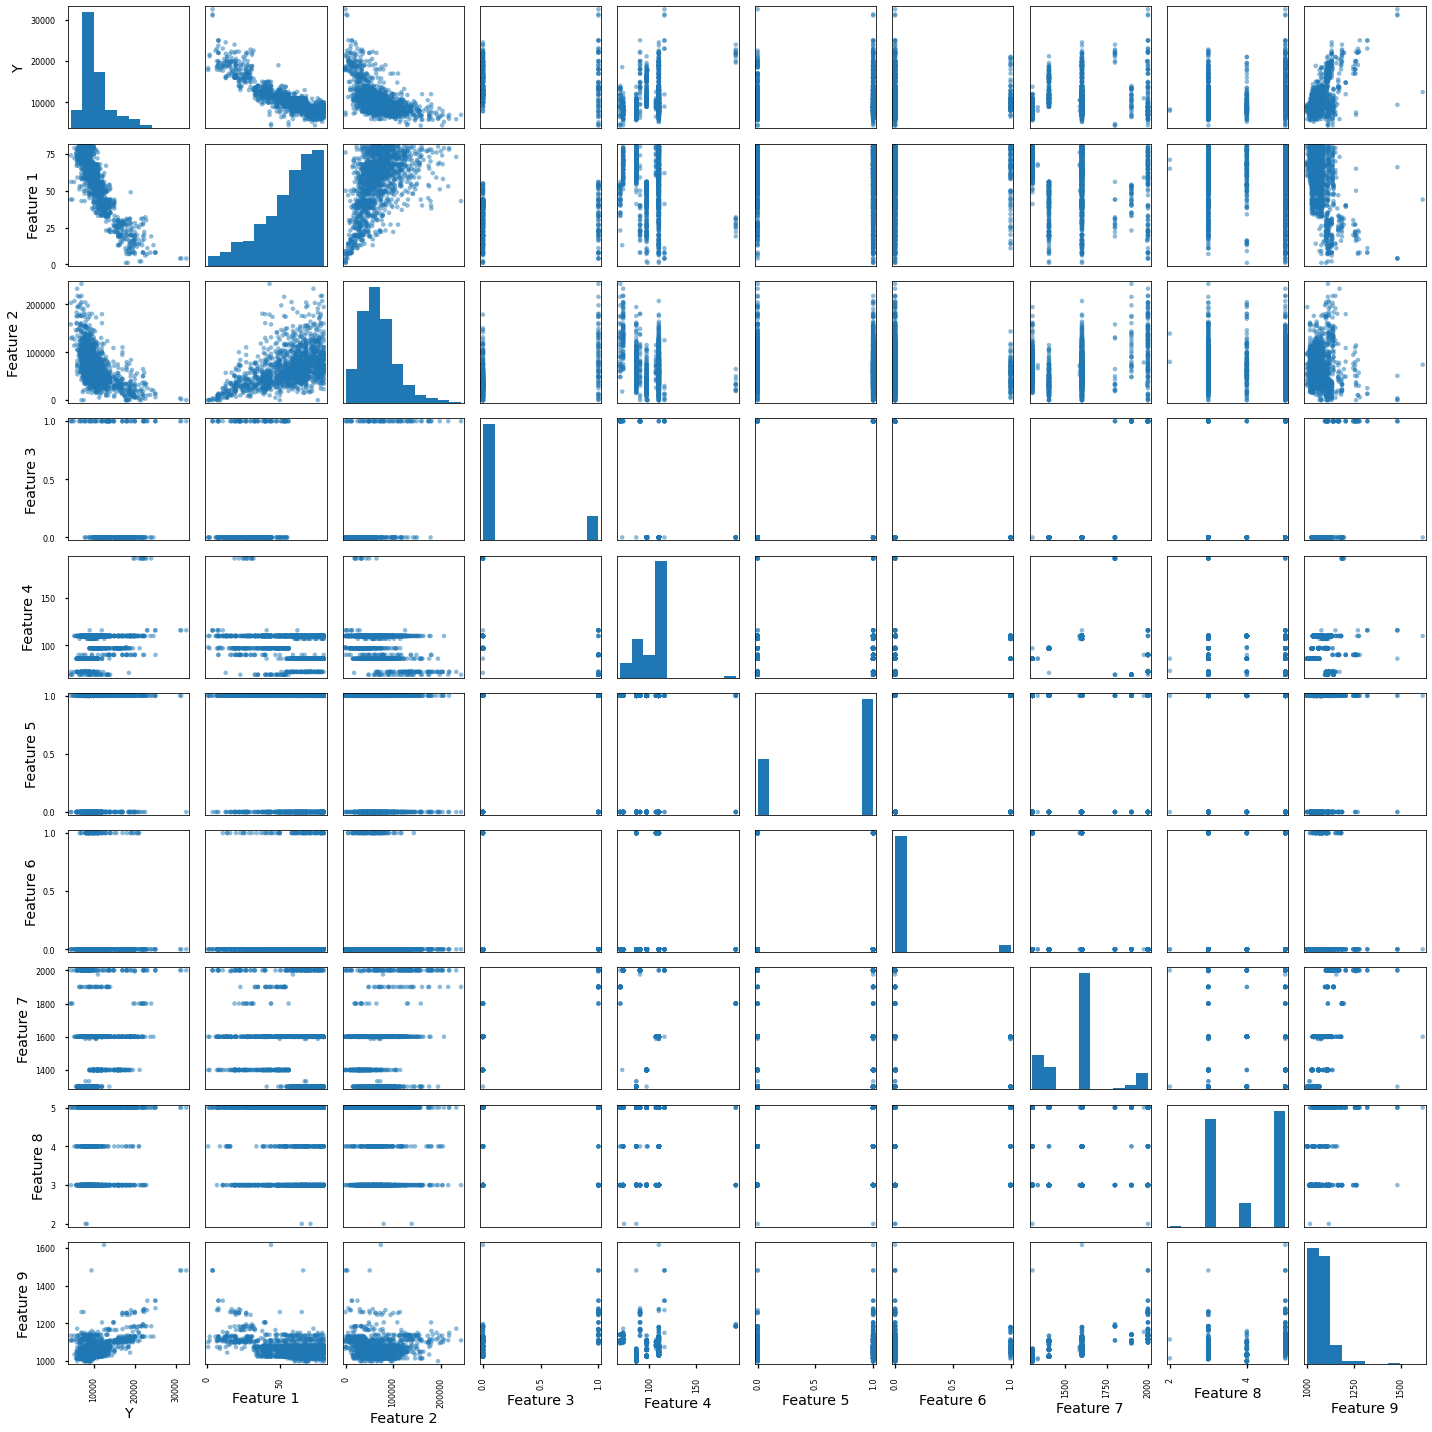

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(20, 20))
scatter_matrix(df, ax=ax)
plt.tight_layout()

## Quick observations:

Univariate
- Y is not normally distrubted. Also, the range of values is high. If not standardized, this create problems in model fitting
- Feature 1 and Feature 2 may need to be normalized
- Feature 5 and Feature 6 can be treated as categorical variables
- Feature 7 and Feature 9 may need to be normalized 
- Feature 8 can be treated as categorical variables
- Feature 1, more samples available at higher values
- Since Feature 3 has missing values, it will be handled separately in this case

Multivariate
- Feature 1 and Y are negatively correlated
- Feature 2 and Y are negatively correlated

In [10]:
# TODO: Do box plots to identify outliers

## Feature-wise EDA

### Response: Y

Text(0.5, 0, '${(log(Y) - \\mu)}/{\\sigma}$')

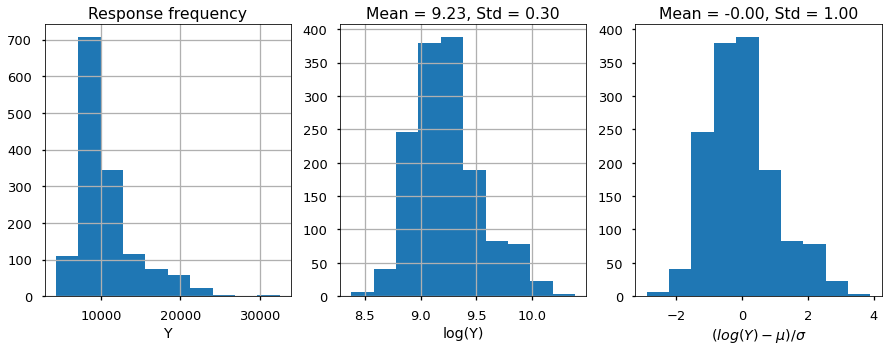

In [11]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5), sharey=False)
df["Y"].hist(ax=ax[0])
ax[0].set_title("Response frequency")
ax[0].set_xlabel("Y")

trans_y = df["Y"].apply(lambda x: np.log(x))
mean_trans_y = trans_y.mean()
std_trans_y = trans_y.std()
trans_y.hist(ax=ax[1])
ax[1].set_title(f"Mean = {mean_trans_y:.2f}, Std = {std_trans_y:.2f}")
ax[1].set_xlabel(f"log(Y)")
# scaler = PowerTransformer(method='box-cox', standardize=True)
scaler = StandardScaler()

standard_trans_y = scaler.fit_transform(trans_y.values.reshape(-1, 1))
mean_trans_y = standard_trans_y.mean()
std_trans_y = standard_trans_y.std()
ax[2].hist(standard_trans_y)
ax[2].set_title(f"Mean = {mean_trans_y:.2f}, Std = {std_trans_y:.2f}")
ax[2].set_xlabel("${(log(Y) - \mu)}/{\sigma}$")
# TODO: Box-cox gives better transform?

Text(0.5, 1.0, 'Quantile Transformer')

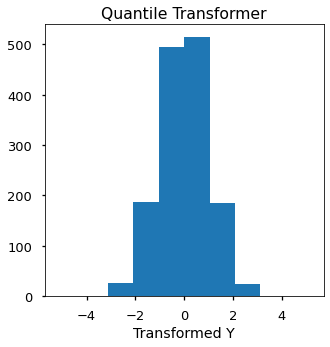

In [12]:
from sklearn.preprocessing import QuantileTransformer
fig,ax = plt.subplots(1,1,figsize=(5,5))
plt.hist(QuantileTransformer(output_distribution="normal").fit_transform(df[["Y"]]));
plt.xlabel("Transformed Y")
plt.title("Quantile Transformer")

*** Revisit 3 - Use quantile tranformer vs log + scale

### Feature 1

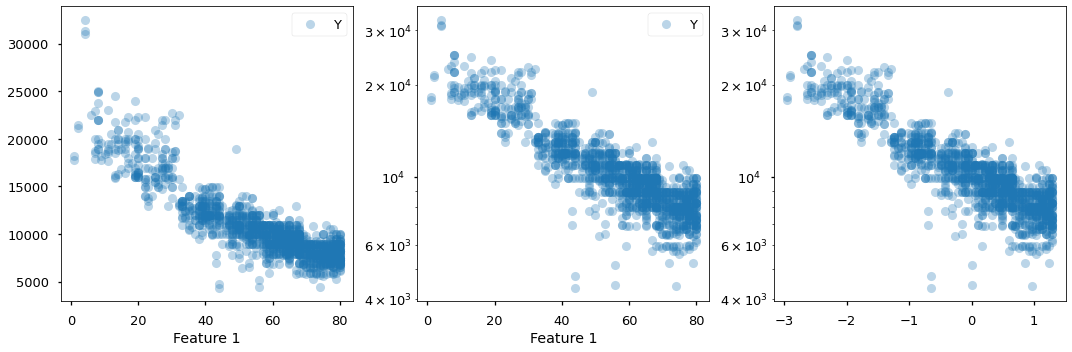

In [13]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax = ax.flatten()
df.plot("Feature 1", "Y", style="o", ax=ax[0], alpha=0.3)
df.plot("Feature 1", "Y", style="o", ax=ax[1], alpha=0.3)
ax[1].set_yscale("log")
ax[2].plot(
    StandardScaler().fit_transform(df[["Feature 1"]]),
    df["Y"],
    "o",
    alpha=0.3,
)
ax[2].set_yscale("log")
# ax[2].set_xscale("log", basex=2)
plt.tight_layout()

### Feature 2

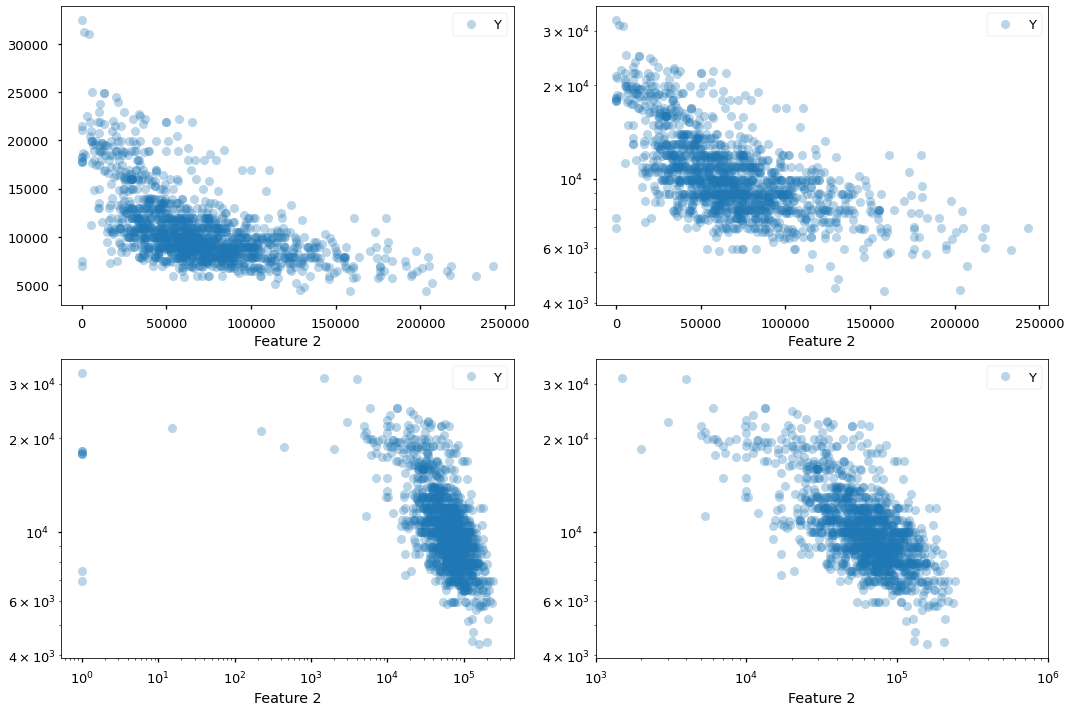

In [14]:
fig, ax = plt.subplots(2, 2, figsize=(15, 10))
ax = ax.flatten()
df.plot("Feature 2", "Y", style="o", ax=ax[0], alpha=0.3)
df.plot("Feature 2", "Y", style="o", ax=ax[1], alpha=0.3)
ax[1].set_yscale("log")
df.plot("Feature 2", "Y", style="o", ax=ax[2], alpha=0.3)
ax[2].set_yscale("log")
ax[2].set_xscale("log")
df.plot("Feature 2", "Y", style="o", ax=ax[3], alpha=0.3)
ax[3].set_yscale("log")
ax[3].set_xscale("log")
ax[3].set_xlim(1000, 1000000)
plt.tight_layout()

Revisit 4: Potential outliers: "Feature 2" < 1000 while using log transformer

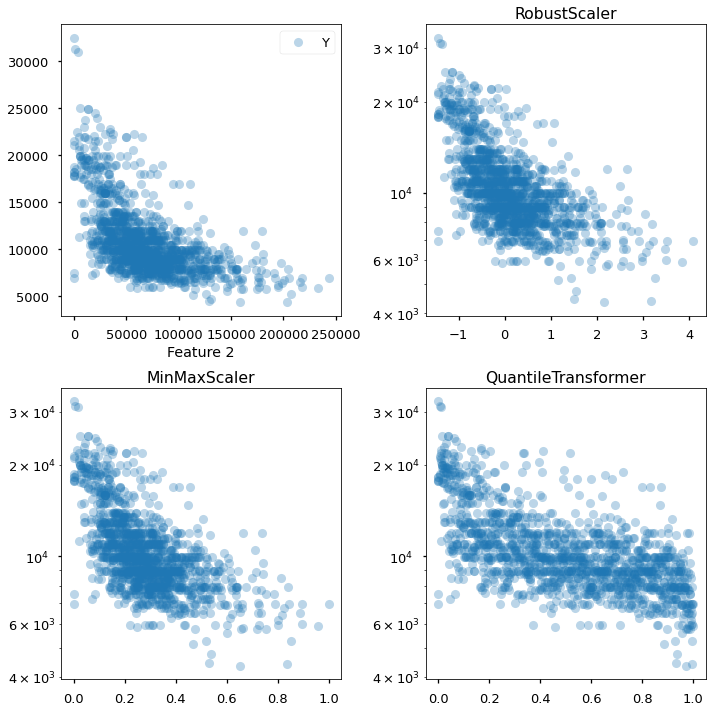

In [15]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
ax = ax.flatten()
df.plot("Feature 2", "Y", style="o", ax=ax[0], alpha=0.3)
ax[1].plot(
    RobustScaler().fit_transform(df[["Feature 2"]]),
    df["Y"],
    "o",
    alpha=0.3,
)
ax[1].set_yscale("log")
ax[1].set_title("RobustScaler")
ax[2].plot(
    MinMaxScaler().fit_transform(df[["Feature 2"]]),
    df["Y"],
    "o",
    alpha=0.3,
)
ax[2].set_title("MinMaxScaler")
ax[2].set_yscale("log")

ax[3].plot(
    QuantileTransformer().fit_transform(df[["Feature 2"]]),
    df["Y"],
    "o",
    alpha=0.3,
)
ax[3].set_title("QuantileTransformer")
ax[3].set_yscale("log")
plt.tight_layout()

Revisit 5: Use QuantileTransformer for Feature 5

### Feature 3

In [16]:
df["Feature 3"].value_counts(dropna=False)

NaN    1022
0.0     342
1.0      72
Name: Feature 3, dtype: int64

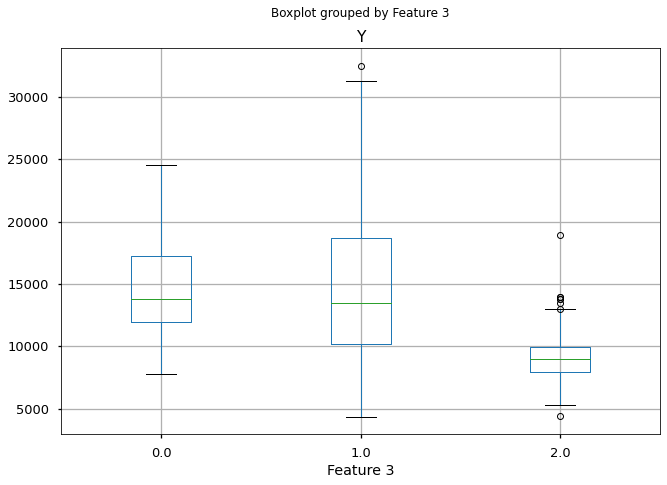

In [17]:
df.fillna(value={"Feature 3": 2}).boxplot(
    "Y", by="Feature 3",
)

Average response with Feature 3 is missing, is visibly less compared to other states.
With minimum infomration about the cause of missing values, we have two options - 
1. Consider missing values as separate category.
2. Ignore Column 3

We will try out both and observe how model results change

### Feature 9

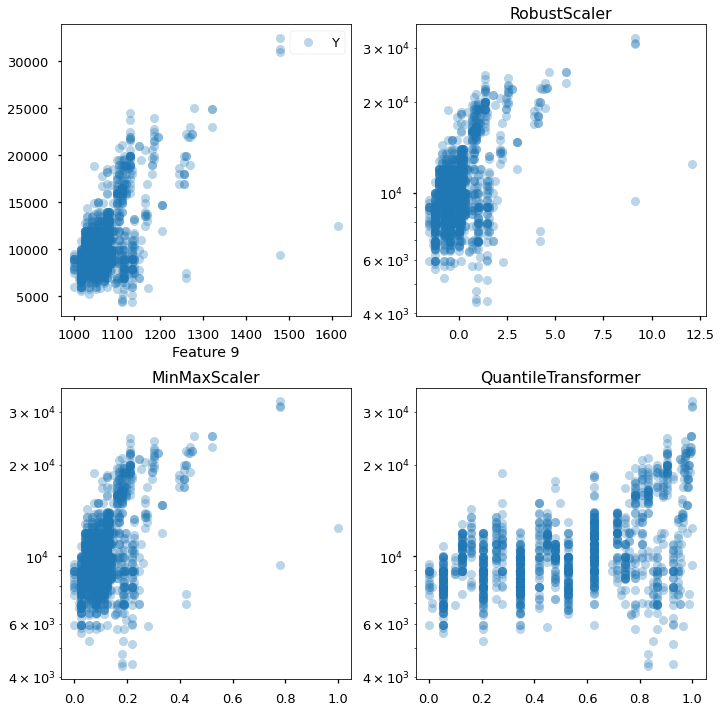

In [18]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
ax = ax.flatten()
df.plot("Feature 9", "Y", style="o", ax=ax[0], alpha=0.3)
ax[1].plot(
    RobustScaler().fit_transform(df["Feature 9"].values.reshape(-1, 1)),
    df["Y"],
    "o",
    alpha=0.3,
)
ax[1].set_yscale("log")
ax[1].set_title("RobustScaler")
ax[2].plot(
    MinMaxScaler().fit_transform(df["Feature 9"].values.reshape(-1, 1)),
    df["Y"],
    "o",
    alpha=0.3,
)
ax[2].set_title("MinMaxScaler")
ax[2].set_yscale("log")

ax[3].plot(
    QuantileTransformer().fit_transform(df["Feature 9"].values.reshape(-1, 1)),
    df["Y"],
    "o",
    alpha=0.3,
)
ax[3].set_title("QuantileTransformer")
ax[3].set_yscale("log")
plt.tight_layout()

Revisit 6: Use Quantile Transformer for Feature 9

### Feature 5,6,8

In [19]:
df["Feature 5"].value_counts()

1    969
0    467
Name: Feature 5, dtype: int64

In [20]:
df["Feature 6"].value_counts()

0    1356
1      80
Name: Feature 6, dtype: int64

In [21]:
df["Feature 8"].value_counts()

5    674
3    622
4    138
2      2
Name: Feature 8, dtype: int64

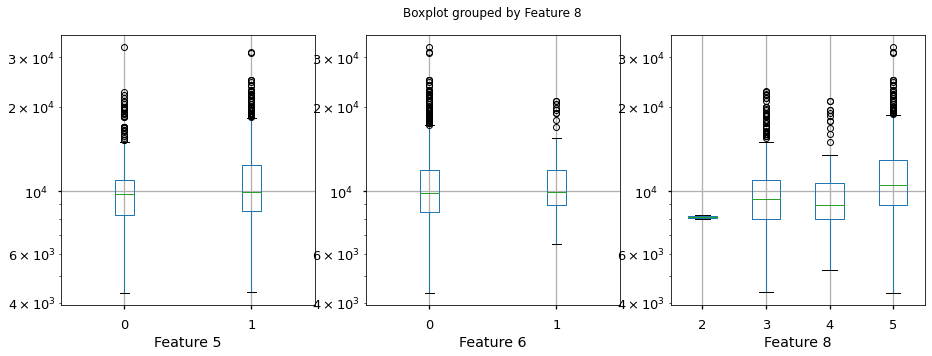

In [22]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for c, ax in zip(["Feature 5", "Feature 6", "Feature 8"], axes):
    df.boxplot("Y", by=c, ax=ax)
    ax.set_yscale("log")
    ax.set_title("")

Observations:
- One hot encoding vs using it as ordinal is a choice for later

*** Revisit 2: Treat Feature 8 as one hot encoded vs ordinal

### Feature 4

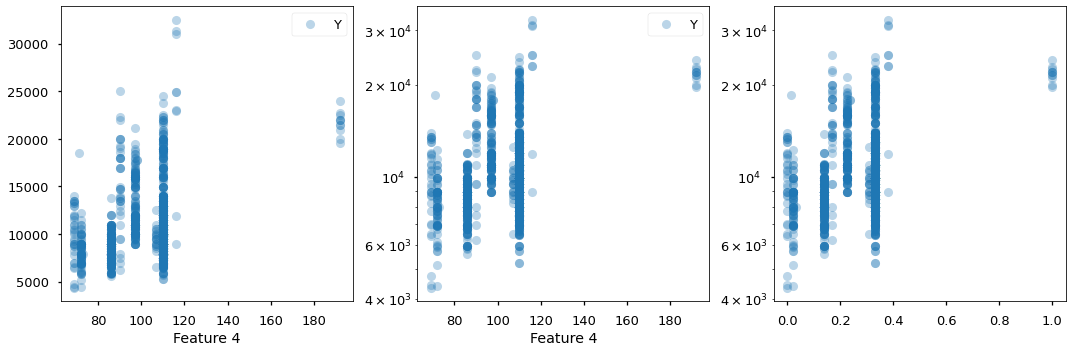

In [23]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax = ax.flatten()
df.plot("Feature 4", "Y", style="o", ax=ax[0], alpha=0.3)
df.plot("Feature 4", "Y", style="o", ax=ax[1], alpha=0.3)
ax[1].set_yscale("log")
ax[2].plot(
    MinMaxScaler().fit_transform(df["Feature 4"].values.reshape(-1, 1)),
    df["Y"],
    "o",
    alpha=0.3,
)
ax[2].set_yscale("log")
# ax[2].set_xscale("log", basex=2)
plt.tight_layout()

### Feature 7

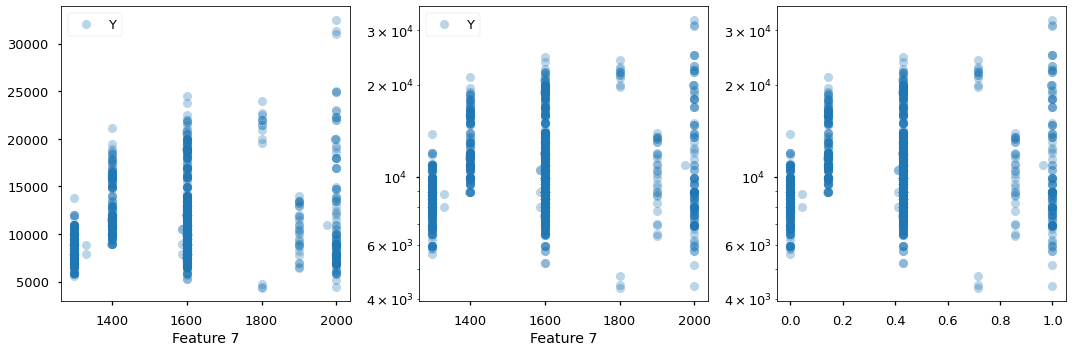

In [24]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax = ax.flatten()
df.plot("Feature 7", "Y", style="o", ax=ax[0], alpha=0.3)
df.plot("Feature 7", "Y", style="o", ax=ax[1], alpha=0.3)
ax[1].set_yscale("log")
ax[2].plot(
    MinMaxScaler().fit_transform(df["Feature 7"].values.reshape(-1, 1)),
    df["Y"],
    "o",
    alpha=0.3,
)
ax[2].set_yscale("log")
# ax[2].set_xscale("log", basex=2)
plt.tight_layout()

# Apply feature transformations

In [25]:
df["Y"] = df["Y"].apply(lambda x: np.log(x))
df_train, df_test = train_test_split(df, test_size=0.2, random_state=2020)

<ipython-input-26-a38381a6101e>:41: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  scatter_matrix(df2, ax=ax, alpha=0.3);


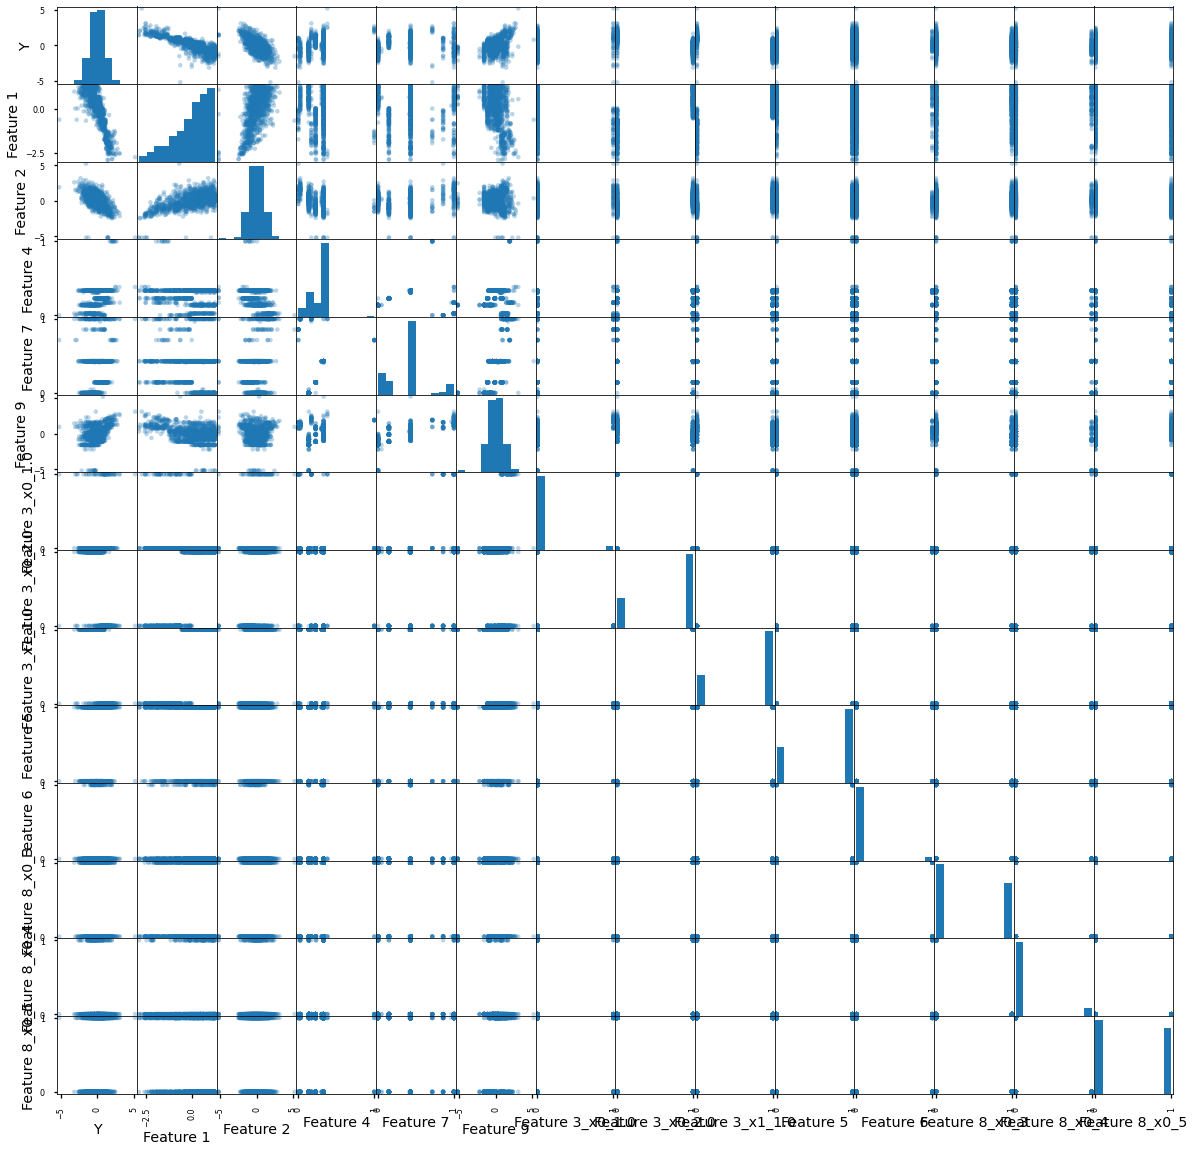

In [26]:
log_transformer = FunctionTransformer(np.log)
log1p_transformer = FunctionTransformer(lambda x: np.log2(1 + x))
# numerical_features = gen_features(columns=[[c] for c in ["Y"]], classes=[transformer])
numerical_features = [
    (["Y"], [QuantileTransformer(output_distribution="normal")]),
    (["Feature 1"], [StandardScaler()]),
    (["Feature 2"], [QuantileTransformer(output_distribution="normal")]),
    (["Feature 4"], [MinMaxScaler()]),
    (["Feature 7"], [MinMaxScaler()]),
    (["Feature 9"], [QuantileTransformer(output_distribution="normal")]),
]
# numerical_features = gen_features(columns=[[c] for c in numerical_columns], classes=[StandardScaler])
categorical_columns = ["Feature 5", "Feature 6", "Feature 8"]
# categorical_features = gen_features(
#    [[c] for c in categorical_columns],
#    classes=[{"class": OneHotEncoder, "drop": "first"}],
# )
categorical_features = [
    (
        ["Feature 3"],
        [
            SimpleImputer(
                missing_values=np.nan,
                strategy="constant",
                fill_value=2,
                add_indicator=True,
            ),
            OneHotEncoder(drop="first"),
        ],
    ),
    (["Feature 5"], OneHotEncoder(drop="first")),
    (["Feature 6"], OneHotEncoder(drop="first")),
    (["Feature 8"], OneHotEncoder(drop="first")),
]
# features = numerical_features + categorical_features
features = numerical_features + categorical_features
mapper = DataFrameMapper(features, df_out=True, input_df=True)
df2 = mapper.fit_transform(df_train)

fig, ax = plt.subplots(1, 1, figsize=(20, 20))
scatter_matrix(df2, ax=ax, alpha=0.3);
# plt.tight_layout()

In [27]:
df2.columns

Index(['Y', 'Feature 1', 'Feature 2', 'Feature 4', 'Feature 7', 'Feature 9',
       'Feature 3_x0_1.0', 'Feature 3_x0_2.0', 'Feature 3_x1_1.0', 'Feature 5',
       'Feature 6', 'Feature 8_x0_3', 'Feature 8_x0_4', 'Feature 8_x0_5'],
      dtype='object')

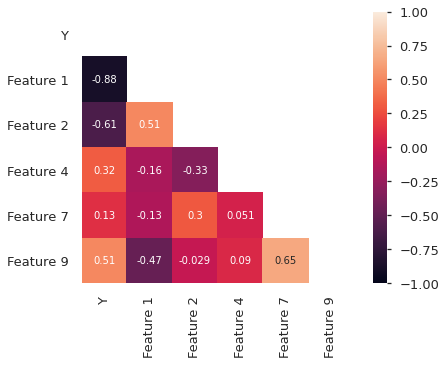

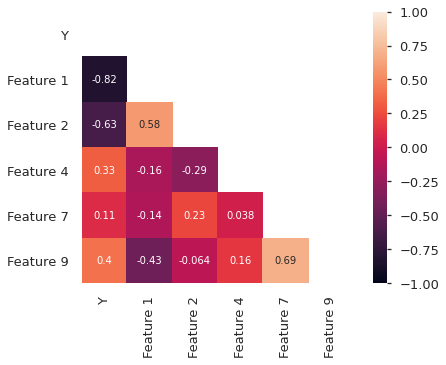

In [28]:
corr = df[
    ["Y", "Feature 1", "Feature 2", "Feature 4", "Feature 7", "Feature 9"]
].corr()
# sns.heatmap(corr, annot=True)
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(7, 5))
    ax = sns.heatmap(corr, mask=mask, vmin=-1, vmax=1, square=True, annot=True)

corr = df2[
    ["Y", "Feature 1", "Feature 2", "Feature 4", "Feature 7", "Feature 9"]
].corr()
# sns.heatmap(corr, annot=True)
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(7, 5))
    ax = sns.heatmap(corr, mask=mask, vmin=-1, vmax=1, square=True, annot=True)

In [29]:
standard_scalar_numerical_columns = [
    "Feature 1",
    "Feature 2",
    "Feature 4",
    "Feature 7",
    "Feature 9",
]

categorical_columns = ["Feature 5", "Feature 6", "Feature 8"]
categorical_pipe = Pipeline([("onehot", OneHotEncoder(drop="first"))])

missing_cat_pipeline = make_pipeline(
    SimpleImputer(
        missing_values=np.nan, strategy="constant", fill_value=2, add_indicator=True,
    ),
    OneHotEncoder(drop="first"),
)

preprocessing = ColumnTransformer(
    [
        (
            "numeric_standard_scalar",
            StandardScaler(),
            standard_scalar_numerical_columns,
        ),
        ("cat", categorical_pipe, categorical_columns),
        ("missing_cat", missing_cat_pipeline, ["Feature 3"],),
    ]
)

In [30]:
preprocessing

ColumnTransformer(transformers=[('numeric_standard_scalar', StandardScaler(),
                                 ['Feature 1', 'Feature 2', 'Feature 4',
                                  'Feature 7', 'Feature 9']),
                                ('cat',
                                 Pipeline(steps=[('onehot',
                                                  OneHotEncoder(drop='first'))]),
                                 ['Feature 5', 'Feature 6', 'Feature 8']),
                                ('missing_cat',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(add_indicator=True,
                                                                fill_value=2,
                                                                strategy='constant')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(drop='first'))]),
                                 ['Feature 3'])])

In [31]:
def plot_prediction(y_pred, y_test, ax=None, scores=None):
    if ax is None:
        f, ax = plt.subplots(1, 1, figsize=(10, 10))
    ax.scatter(y_test, y_pred, alpha=0.3)
    ax.plot([8.5, 10.5], [8.5, 10.5], "--r")
    ax.set_ylabel("Target predicted")
    ax.set_xlabel("True Target")
    extra = plt.Rectangle(
        (0, 0), 0, 0, fc="w", fill=False, edgecolor="none", linewidth=0
    )
    if scores:
        ax.legend([extra], [scores], loc="upper left")

# Quick modeling

## Benchmark (Univariate model)

In [32]:
from sklearn.dummy import DummyRegressor
from sklearn.compose import TransformedTargetRegressor

In [33]:
X_train = df_train.drop("Y", axis=1)
y_train = df_train["Y"]
X_test = df_test.drop("Y", axis=1)
y_test = df_test["Y"]
dummy = TransformedTargetRegressor(
    regressor=Pipeline(
        [
            ("preprocessor", preprocessing),
            ("regressor", DummyRegressor(strategy="mean")),
            # ]).fit(df_train, df_train["Y"])
        ]
    ),
    transformer=StandardScaler(),
).fit(X_train, y_train)
y_pred = dummy.predict(X_test)
print(f"Training score: {dummy.score(X_train, y_train)}")
print(f"Test score: {dummy.score(X_test,y_test)}")

Training score: 0.0
Test score: -0.001905048641068774


In [34]:
np.sqrt(mean_squared_error(y_test, y_pred))

0.2822524604738005

In [35]:
dummy

TransformedTargetRegressor(regressor=Pipeline(steps=[('preprocessor',
                                                      ColumnTransformer(transformers=[('numeric_standard_scalar',
                                                                                       StandardScaler(),
                                                                                       ['Feature '
                                                                                        '1',
                                                                                        'Feature '
                                                                                        '2',
                                                                                        'Feature '
                                                                                        '4',
                                                                                        'Feature '
                                                                                        '7',
                                                                                        'Feature '
                                                                                        '9']),
                                                                                      ('cat',
                                                                                       Pipeline(steps=[('onehot',
                                                                                                        OneHotEncoder(drop='first'))]),
                                                                                       ['Feature '
                                                                                        '5',
                                                                                        'Feature '
                                                                                        '6',
                                                                                        'Feature '
                                                                                        '8']),
                                                                                      ('missing_cat',
                                                                                       Pipeline(steps=[('simpleimputer',
                                                                                                        SimpleImputer(add_indicator=True,
                                                                                                                      fill_value=2,
                                                                                                                      strategy='constant')),
                                                                                                       ('onehotencoder',
                                                                                                        OneHotEncoder(drop='first'))]),
                                                                                       ['Feature '
                                                                                        '3'])])),
                                                     ('regressor',
                                                      DummyRegressor())]),
                           transformer=StandardScaler())

## ElasticNet

Use standardization and normalization based on https://medium.com/@swethalakshmanan14/how-when-and-why-should-you-normalize-standardize-rescale-your-data-3f083def38ff

In [36]:
X_train = df_train.drop("Y", axis=1)
y_train = df_train["Y"]
X_test = df_test.drop("Y", axis=1)
y_test = df_test["Y"]
elastic_reg = TransformedTargetRegressor(
    regressor=Pipeline(
        [("preprocessor", preprocessing), ("regressor", ElasticNet()),]
    ),
    transformer=StandardScaler(),
).fit(X_train, y_train)
y_pred = elastic_reg.predict(X_test)
print(f"Training score: {elastic_reg.score(X_train, y_train)}")
print(f"Test score: {elastic_reg.score(X_test, y_test)}")

Training score: 0.37602065436726906
Test score: 0.3723092650151174


In [37]:
np.sqrt(mean_squared_error(y_test, y_pred))

0.2234072759282148

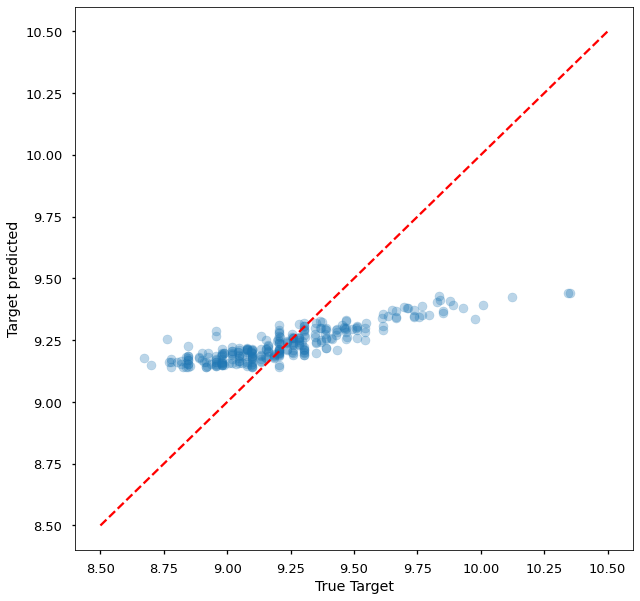

In [38]:
plot_prediction(y_pred=y_pred, y_test=y_test)

1. The default parameters for the model would overfit. 
2. This can be seen with very high training score.
3. Searching for the best parameter, reduces the training score while keeping cross-validation score "similar"

## HistGradientBooster

In [39]:
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor

In [40]:
X_train = df_train.drop("Y", axis=1)
y_train = df_train["Y"]
X_test = df_test.drop("Y", axis=1)
y_test = df_test["Y"]
hist_reg = TransformedTargetRegressor(
    regressor=Pipeline(
        [
            ("preprocessor", preprocessing),
            ("regressor", HistGradientBoostingRegressor()),
        ]
    ),
    transformer=StandardScaler(),
).fit(X_train, y_train)
y_pred = hist_reg.predict(X_test)
print(f"Training score: {hist_reg.score(X_train, y_train)}")
print(f"Test score: {hist_reg.score(X_test, y_test)}")

Training score: 0.9472668264839389
Test score: 0.8543243904957898


In [41]:
hist_reg

TransformedTargetRegressor(regressor=Pipeline(steps=[('preprocessor',
                                                      ColumnTransformer(transformers=[('numeric_standard_scalar',
                                                                                       StandardScaler(),
                                                                                       ['Feature '
                                                                                        '1',
                                                                                        'Feature '
                                                                                        '2',
                                                                                        'Feature '
                                                                                        '4',
                                                                                        'Feature '
                                                                                        '7',
                                                                                        'Feature '
                                                                                        '9']),
                                                                                      ('cat',
                                                                                       Pipeline(steps=[('onehot',
                                                                                                        OneHotEncoder(drop='first'))]),
                                                                                       ['Feature '
                                                                                        '5',
                                                                                        'Feature '
                                                                                        '6',
                                                                                        'Feature '
                                                                                        '8']),
                                                                                      ('missing_cat',
                                                                                       Pipeline(steps=[('simpleimputer',
                                                                                                        SimpleImputer(add_indicator=True,
                                                                                                                      fill_value=2,
                                                                                                                      strategy='constant')),
                                                                                                       ('onehotencoder',
                                                                                                        OneHotEncoder(drop='first'))]),
                                                                                       ['Feature '
                                                                                        '3'])])),
                                                     ('regressor',
                                                      HistGradientBoostingRegressor())]),
                           transformer=StandardScaler())

In [42]:
np.sqrt(mean_squared_error(y_test, y_pred))

0.10762616757083683

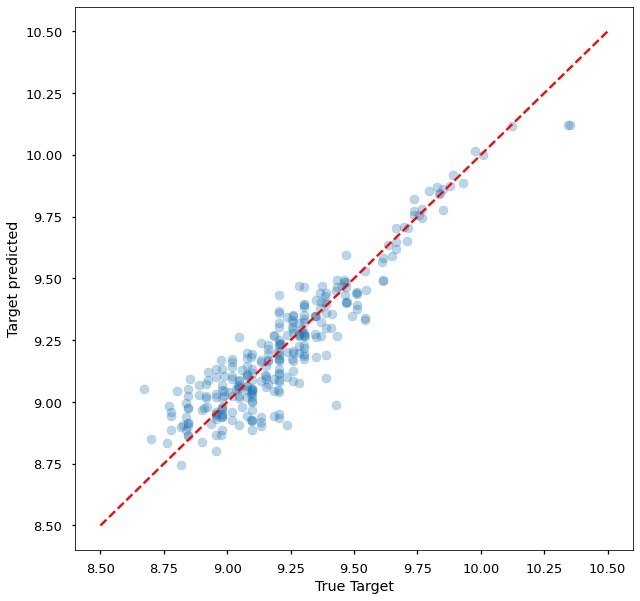

In [43]:
plot_prediction(y_pred=y_pred, y_test=y_test)

https://github.com/scikit-learn/scikit-learn/issues/15132

TODO: Read https://scikit-learn.org/stable/modules/permutation_importance.html

The impurity-based feature importance ranks the numerical features to be the most important features. As a result, the non-predictive random_num variable is ranked the most important! Source - https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance.html#sphx-glr-auto-examples-inspection-plot-permutation-importance-py

https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance_multicollinear.html#sphx-glr-auto-examples-inspection-plot-permutation-importance-multicollinear-py

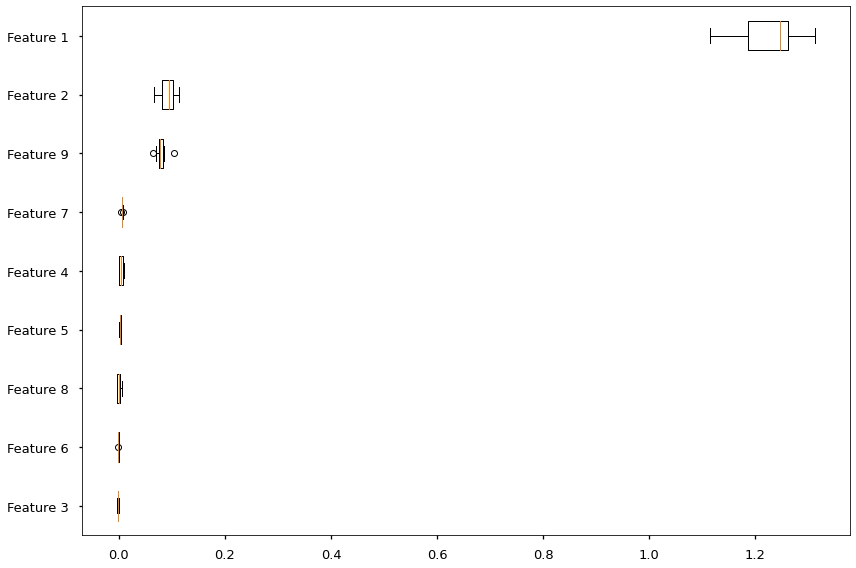

In [44]:
from sklearn.inspection import permutation_importance

est = hist_reg
result = permutation_importance(est, X_test, y_test, n_repeats=10, random_state=42)
perm_sorted_idx = result.importances_mean.argsort()

# tree_importance_sorted_idx = np.argsort(est.named_steps["regressor"].feature_importances_)
# tree_indices = np.arange(0, len(est.feature_importances_)) + 0.5

fig, ax2 = plt.subplots(1, 1, figsize=(12, 8))
ax2.boxplot(
    result.importances[perm_sorted_idx].T,
    vert=False,
    labels=X_train.columns[perm_sorted_idx],
)
fig.tight_layout()
plt.show()

# Pipeline with GridSearch CV

## ElasticNet

In [45]:
X_train = df_train.drop("Y", axis=1)
y_train = df_train["Y"]
X_test = df_test.drop("Y", axis=1)
y_test = df_test["Y"]
pipe = TransformedTargetRegressor(
    regressor=Pipeline([("preprocessor", preprocessing), ("regressor", ElasticNet()),]),
    transformer=StandardScaler(),
)
param_grid = {
    "regressor__regressor__alpha": (0.001, 0.01, 0.1, 1.0),
    "regressor__regressor__l1_ratio": (0.05, 0.2, 0.5, 0.7, 0.9, 1.0),
}
search = GridSearchCV(pipe, param_grid=param_grid, cv=5,).fit(X_train, y_train)
y_pred = search.predict(X_test)
print(f"Training score: {search.score(X_train, y_train):.3f}")
print(f"Cross-val score: {search.best_score_:.3f}")
print(f"Test score: {r2_score(y_test, y_pred):.3f}")

Training score: 0.842
Cross-val score: 0.840
Test score: 0.861


In [46]:
search.best_estimator_

TransformedTargetRegressor(regressor=Pipeline(steps=[('preprocessor',
                                                      ColumnTransformer(transformers=[('numeric_standard_scalar',
                                                                                       StandardScaler(),
                                                                                       ['Feature '
                                                                                        '1',
                                                                                        'Feature '
                                                                                        '2',
                                                                                        'Feature '
                                                                                        '4',
                                                                                        'Feature '
                                                                                        '7',
                                                                                        'Feature '
                                                                                        '9']),
                                                                                      ('cat',
                                                                                       Pipeline(steps=[('onehot',
                                                                                                        OneHotEncoder(drop='first'))]),
                                                                                       ['Feature '
                                                                                        '5',
                                                                                        'Feature '
                                                                                        '6',
                                                                                        'Feature '
                                                                                        '8']),
                                                                                      ('missing_cat',
                                                                                       Pipeline(steps=[('simpleimputer',
                                                                                                        SimpleImputer(add_indicator=True,
                                                                                                                      fill_value=2,
                                                                                                                      strategy='constant')),
                                                                                                       ('onehotencoder',
                                                                                                        OneHotEncoder(drop='first'))]),
                                                                                       ['Feature '
                                                                                        '3'])])),
                                                     ('regressor',
                                                      ElasticNet(alpha=0.01,
                                                                 l1_ratio=1.0))]),
                           transformer=StandardScaler())

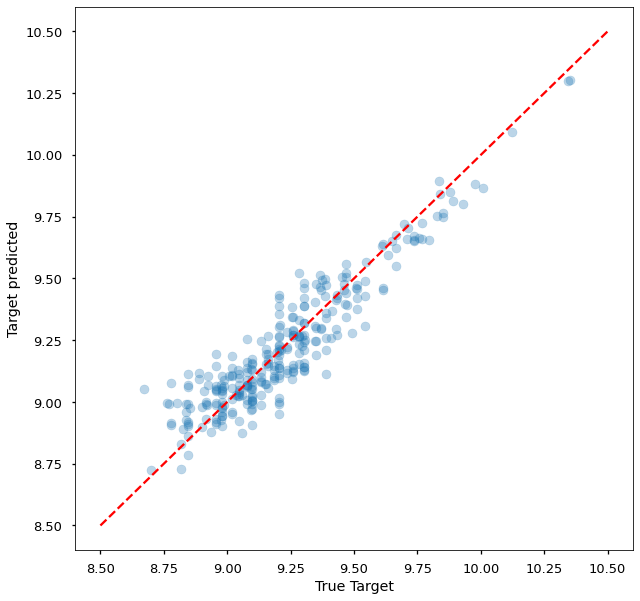

In [47]:
plot_prediction(y_pred=y_pred, y_test=y_test)

## HistGradientBooster

In [48]:
X_train = df_train.drop("Y", axis=1)
y_train = df_train["Y"]
X_test = df_test.drop("Y", axis=1)
y_test = df_test["Y"]
param_grid = {
    "regressor__regressor__l2_regularization": [0.0, 0.5, 1.0],
    "regressor__regressor__max_depth": [6, 15, 20],
    "regressor__regressor__max_iter": [100, 200],
}
pipe = TransformedTargetRegressor(
    regressor=Pipeline(
        [
            ("preprocessor", preprocessing),
            ("regressor", HistGradientBoostingRegressor()),
        ]
    ),
    transformer=StandardScaler(),
)
search = GridSearchCV(pipe, param_grid=param_grid, cv=5,).fit(X_train, y_train)
y_pred = search.predict(X_test)
print(f"Training score: {search.score(X_train, y_train):.3f}")
print(f"Cross-val score: {search.best_score_:.3f}")
print(f"Test score: {r2_score(y_test, y_pred):.3f}")

Training score: 0.926
Cross-val score: 0.850
Test score: 0.865


In [49]:
search.best_estimator_

TransformedTargetRegressor(regressor=Pipeline(steps=[('preprocessor',
                                                      ColumnTransformer(transformers=[('numeric_standard_scalar',
                                                                                       StandardScaler(),
                                                                                       ['Feature '
                                                                                        '1',
                                                                                        'Feature '
                                                                                        '2',
                                                                                        'Feature '
                                                                                        '4',
                                                                                        'Feature '
                                                                                        '7',
                                                                                        'Feature '
                                                                                        '9']),
                                                                                      ('cat',
                                                                                       Pipeline(steps=[('onehot',
                                                                                                        OneHotEncoder(drop='first'))]),
                                                                                       ['Feature '
                                                                                        '5',
                                                                                        'Feature '
                                                                                        '6',
                                                                                        'Feature '
                                                                                        '8']),
                                                                                      ('missing_cat',
                                                                                       Pipeline(steps=[('simpleimputer',
                                                                                                        SimpleImputer(add_indicator=True,
                                                                                                                      fill_value=2,
                                                                                                                      strategy='constant')),
                                                                                                       ('onehotencoder',
                                                                                                        OneHotEncoder(drop='first'))]),
                                                                                       ['Feature '
                                                                                        '3'])])),
                                                     ('regressor',
                                                      HistGradientBoostingRegressor(l2_regularization=0.5,
                                                                                    max_depth=6))]),
                           transformer=StandardScaler())

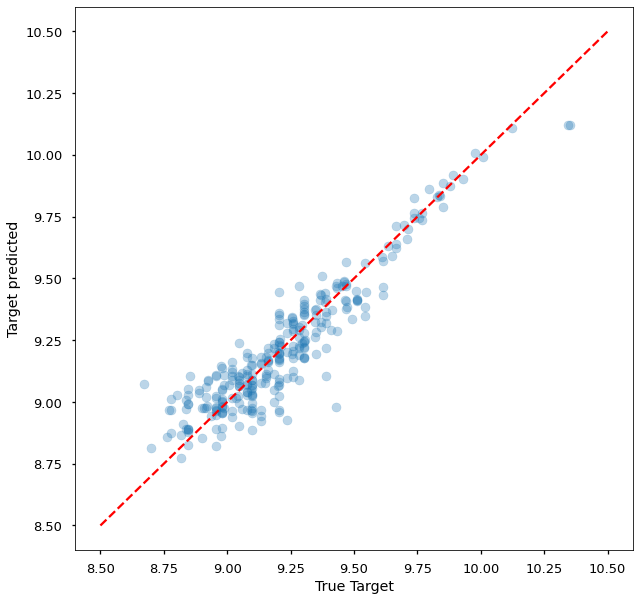

In [50]:
plot_prediction(y_pred=y_pred, y_test=y_test)

## RandomForest

In [51]:
X_train = df_train.drop("Y", axis=1)
y_train = df_train["Y"]
X_test = df_test.drop("Y", axis=1)
y_test = df_test["Y"]
param_grid = {
    "regressor__regressor__n_estimators": [50, 100, 200, 300],
    "regressor__regressor__max_depth": [5, 6, 7, 8, 15, 20],
}
pipe = TransformedTargetRegressor(
    regressor=Pipeline(
        [("preprocessor", preprocessing), ("regressor", RandomForestRegressor()),]
    ),
    transformer=StandardScaler(),
)
search = GridSearchCV(pipe, param_grid=param_grid, cv=5,).fit(X_train, y_train)
y_pred = search.predict(X_test)
print(f"Training score: {search.score(X_train, y_train):.3f}")
print(f"Cross-val score: {search.best_score_:.3f}")
print(f"Test score: {search.score(X_test, y_test):.3f}")

Training score: 0.913
Cross-val score: 0.852
Test score: 0.876


In [52]:
search.best_estimator_

TransformedTargetRegressor(regressor=Pipeline(steps=[('preprocessor',
                                                      ColumnTransformer(transformers=[('numeric_standard_scalar',
                                                                                       StandardScaler(),
                                                                                       ['Feature '
                                                                                        '1',
                                                                                        'Feature '
                                                                                        '2',
                                                                                        'Feature '
                                                                                        '4',
                                                                                        'Feature '
                                                                                        '7',
                                                                                        'Feature '
                                                                                        '9']),
                                                                                      ('cat',
                                                                                       Pipeline(steps=[('onehot',
                                                                                                        OneHotEncoder(drop='first'))]),
                                                                                       ['Feature '
                                                                                        '5',
                                                                                        'Feature '
                                                                                        '6',
                                                                                        'Feature '
                                                                                        '8']),
                                                                                      ('missing_cat',
                                                                                       Pipeline(steps=[('simpleimputer',
                                                                                                        SimpleImputer(add_indicator=True,
                                                                                                                      fill_value=2,
                                                                                                                      strategy='constant')),
                                                                                                       ('onehotencoder',
                                                                                                        OneHotEncoder(drop='first'))]),
                                                                                       ['Feature '
                                                                                        '3'])])),
                                                     ('regressor',
                                                      RandomForestRegressor(max_depth=6,
                                                                            n_estimators=50))]),
                           transformer=StandardScaler())

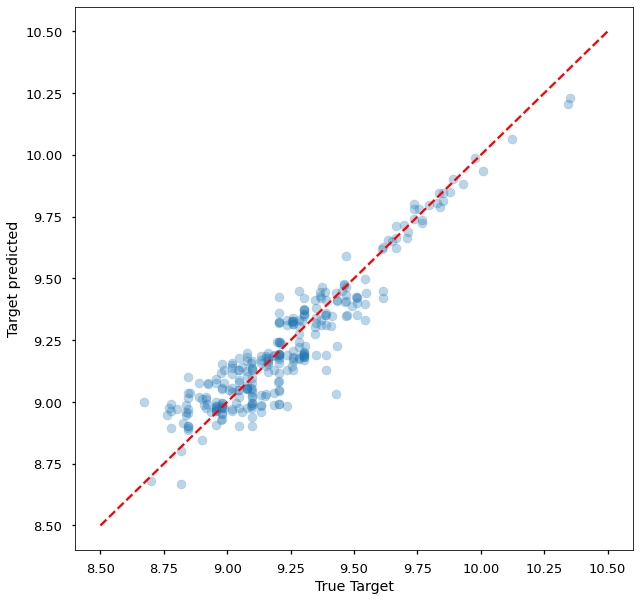

In [53]:
plot_prediction(y_pred=y_pred, y_test=y_test)

Observation:
    - Seem to predict well at high values compares to smaller values

# Putting it all together

1. Remove outiers
2. Remove unimportant features

Estimator: ElasticNet
Training score: 0.842
Cross-val score: 0.840
Test score: 0.861
----------
Estimator: RandomForest
Training score: 0.913
Cross-val score: 0.852
Test score: 0.880
----------
Estimator: HistGradientBoost
Training score: 0.926
Cross-val score: 0.850
Test score: 0.865
----------


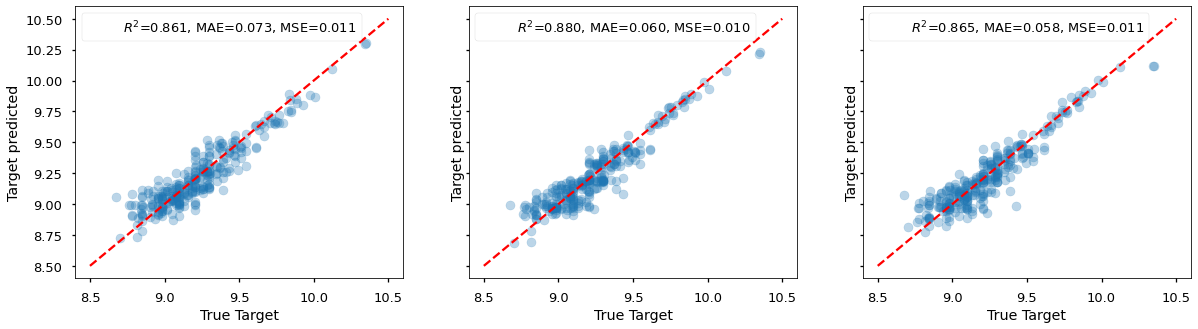

In [54]:
X_train = df_train.drop("Y", axis=1)
y_train = df_train["Y"]
X_test = df_test.drop("Y", axis=1)
y_test = df_test["Y"]

# Preprocessing
standard_scalar_numerical_columns = [
    "Feature 1",
    "Feature 2",
    "Feature 4",
    "Feature 7",
    "Feature 9",
]

categorical_columns = ["Feature 5", "Feature 6", "Feature 8"]
categorical_pipe = Pipeline([("onehot", OneHotEncoder(drop="first"))])

missing_cat_pipeline = make_pipeline(
    SimpleImputer(
        missing_values=np.nan, strategy="constant", fill_value=2, add_indicator=True,
    ),
    OneHotEncoder(drop="first"),
)

preprocessing = ColumnTransformer(
    [
        (
            "numeric_standard_scalar",
            StandardScaler(),
            standard_scalar_numerical_columns,
        ),
        ("cat", categorical_pipe, categorical_columns),
        ("missing_cat", missing_cat_pipeline, ["Feature 3"],),
    ]
)

# ElasticNet (alpha = 1.0 -> Lasso)
param_grid = {
    "regressor__regressor__alpha": (0.001, 0.01, 0.1, 1.0),
    "regressor__regressor__l1_ratio": (0.05, 0.2, 0.5, 0.7, 0.9, 1.0),
}
en_pipe = TransformedTargetRegressor(
    regressor=Pipeline([("preprocessor", preprocessing), ("regressor", ElasticNet()),]),
    transformer=StandardScaler(),
)
en_search = GridSearchCV(en_pipe, param_grid=param_grid, cv=5,)

# RandomForest
param_grid = {
    "regressor__regressor__n_estimators": [50, 100, 200, 300],
    "regressor__regressor__max_depth": [5, 6, 7, 8, 15, 20],
}
rf_pipe = TransformedTargetRegressor(
    regressor=Pipeline(
        [("preprocessor", preprocessing), ("regressor", RandomForestRegressor()),]
    ),
    transformer=StandardScaler(),
)
rf_search = GridSearchCV(rf_pipe, param_grid=param_grid, cv=5,)

# HistGradientBoost
param_grid = {
    "regressor__regressor__l2_regularization": [0.0, 0.5, 1.0],
    "regressor__regressor__max_depth": [6, 15, 20],
    "regressor__regressor__max_iter": [100, 200],
}
hgb_pipe = TransformedTargetRegressor(
    regressor=Pipeline(
        [
            ("preprocessor", preprocessing),
            ("regressor", HistGradientBoostingRegressor()),
        ]
    ),
    transformer=StandardScaler(),
)
hgb_search = GridSearchCV(hgb_pipe, param_grid=param_grid, cv=5,)

estimators = {
    "ElasticNet": en_search,
    "RandomForest": rf_search,
    "HistGradientBoost": hgb_search,
}

fig, axes = plt.subplots(1, 3, figsize=(20, 5), sharey=True)
for ax, (estimator_name, estimator) in zip(axes, estimators.items()):
    reg = estimator.fit(X_train, y_train)
    y_pred = reg.predict(X_test)
    print(f"Estimator: {estimator_name}")
    print(f"Training score: {reg.score(X_train, y_train):.3f}")
    print(f"Cross-val score: {reg.best_score_:.3f}")
    print(f"Test score: {r2_score(y_test, y_pred):.3f}")
    print(f"----------")
    scores = r"$R^2$=%.3f, MAE=%.3f, MSE=%.3f" % (
        r2_score(y_test, y_pred),
        median_absolute_error(y_test, y_pred),
        mean_squared_error(y_test, y_pred),
    )
    plot_prediction(y_test=y_test, y_pred=y_pred, ax=ax, scores=scores)

# Fitting models in automated way

We have all the building blocks for developing models quickly. 

With the pipelines of preprocessing and GridSearchCV defined, we can fit multiple estimators in one-go and test our hypothesis.

For code hygiene, the above pieces are packaged into a Python Package. It is available here - https://github.com/pushkarjain/model-turbostart

In [55]:
from sklearn_turbostart.estimators import create_estimators
from sklearn_turbostart.train import load_data, plot_prediction, train_estimators, plot_permutation_importance

## Using StandardScaler for numerical columns

Note that Feature 3 is not dropped here. Feature 3 missing values are imputed with new categories and are one-hot encoded

In [56]:
X_train, y_train, X_test, y_test = load_data("../data/data.csv")

standard_scalar_numerical_columns = [
    "Feature 1",
    "Feature 2",
    "Feature 4",
    "Feature 7",
    "Feature 9",
]

categorical_columns = ["Feature 5", "Feature 6", "Feature 8"]
categorical_pipe = Pipeline([("onehot", OneHotEncoder(drop="first"))])

missing_cat_pipeline = make_pipeline(
    SimpleImputer(
        missing_values=np.nan, strategy="constant", fill_value=2, add_indicator=True,
    ),
    OneHotEncoder(drop="first"),
)

preprocessing = ColumnTransformer(
    [
        (
            "numeric_standard_scalar",
            StandardScaler(),
            standard_scalar_numerical_columns,
        ),
        ("cat", categorical_pipe, categorical_columns),
        ("missing_cat", missing_cat_pipeline, ["Feature 3"],),
    ]
)

estimators = create_estimators(preprocessing)
preprocessing

INFO:sklearn_turbostart.train:Transforming Y to log(Y)
INFO:sklearn_turbostart.train:Splitting data as 80/20


ColumnTransformer(transformers=[('numeric_standard_scalar', StandardScaler(),
                                 ['Feature 1', 'Feature 2', 'Feature 4',
                                  'Feature 7', 'Feature 9']),
                                ('cat',
                                 Pipeline(steps=[('onehot',
                                                  OneHotEncoder(drop='first'))]),
                                 ['Feature 5', 'Feature 6', 'Feature 8']),
                                ('missing_cat',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(add_indicator=True,
                                                                fill_value=2,
                                                                strategy='constant')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(drop='first'))]),
                                 ['Feature 3'])])

Estimator: ElasticNet
Training score: 0.842
Cross-val score: 0.840
Test score: 0.861
----------
Estimator: RandomForest
Training score: 0.912
Cross-val score: 0.852
Test score: 0.878
----------
Estimator: HistGradientBoost
Training score: 0.926
Cross-val score: 0.850
Test score: 0.861
----------


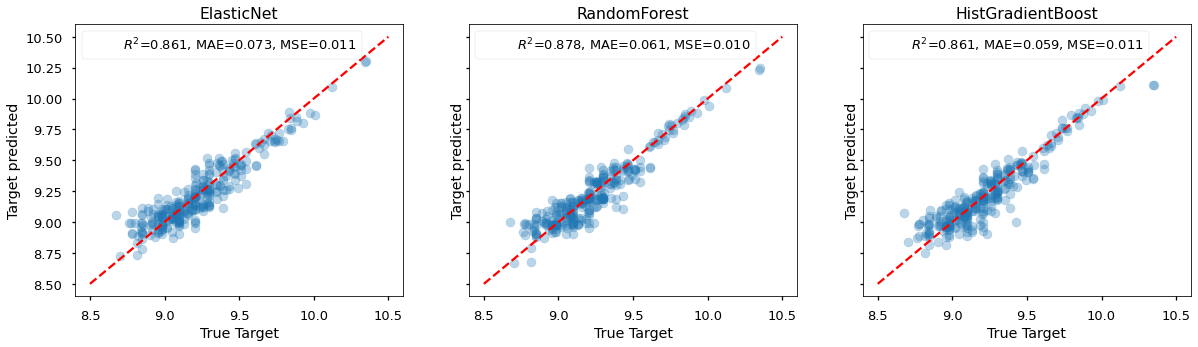

In [57]:
train_estimators(estimators, X_train, y_train, X_test, y_test)

In [58]:
estimators["HistGradientBoost"].best_estimator_

TransformedTargetRegressor(regressor=Pipeline(steps=[('preprocessor',
                                                      ColumnTransformer(transformers=[('numeric_standard_scalar',
                                                                                       StandardScaler(),
                                                                                       ['Feature '
                                                                                        '1',
                                                                                        'Feature '
                                                                                        '2',
                                                                                        'Feature '
                                                                                        '4',
                                                                                        'Feature '
                                                                                        '7',
                                                                                        'Feature '
                                                                                        '9']),
                                                                                      ('cat',
                                                                                       Pipeline(steps=[('onehot',
                                                                                                        OneHotEncoder(drop='first'))]),
                                                                                       ['Feature '
                                                                                        '5',
                                                                                        'Feature '
                                                                                        '6',
                                                                                        'Feature '
                                                                                        '8']),
                                                                                      ('missing_cat',
                                                                                       Pipeline(steps=[('simpleimputer',
                                                                                                        SimpleImputer(add_indicator=True,
                                                                                                                      fill_value=2,
                                                                                                                      strategy='constant')),
                                                                                                       ('onehotencoder',
                                                                                                        OneHotEncoder(drop='first'))]),
                                                                                       ['Feature '
                                                                                        '3'])])),
                                                     ('regressor',
                                                      HistGradientBoostingRegressor(l2_regularization=1.0,
                                                                                    max_depth=6))]),
                           transformer=StandardScaler())

INFO:sklearn_turbostart.train:['Feature 1', 'Feature 2', 'Feature 4', 'Feature 7', 'Feature 9', 'x0_1', 'x1_1', 'x2_3', 'x2_4', 'x2_5', 'x0_1.0', 'x0_2.0', 'x1_1.0']
INFO:sklearn_turbostart.train:['Feature 1', 'Feature 2', 'Feature 4', 'Feature 7', 'Feature 9', 'x0_1', 'x1_1', 'x2_3', 'x2_4', 'x2_5', 'x0_1.0', 'x0_2.0', 'x1_1.0']
INFO:sklearn_turbostart.train:['Feature 1', 'Feature 2', 'Feature 4', 'Feature 7', 'Feature 9', 'x0_1', 'x1_1', 'x2_3', 'x2_4', 'x2_5', 'x0_1.0', 'x0_2.0', 'x1_1.0']


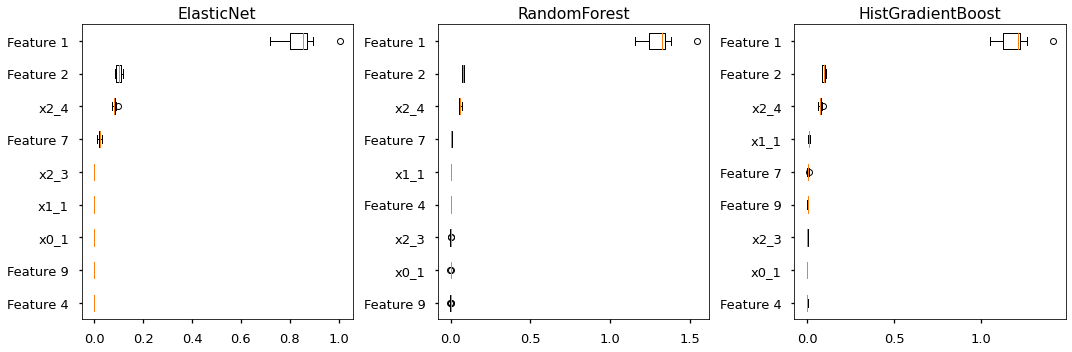

In [59]:
plot_permutation_importance(estimators, X_test, y_test)

Feature 1, 2, Feature 7 and Feature 8 look important

## Change Feature 8 to ordinal

In [60]:
X_train, y_train, X_test, y_test = load_data("../data/data.csv")

standard_scalar_numerical_columns = [
    "Feature 1",
    "Feature 2",
    "Feature 4",
    "Feature 7",
    "Feature 9",
]

categorical_columns = ["Feature 5", "Feature 6"]
categorical_pipe = Pipeline([("onehot", OneHotEncoder(drop="first"))])

missing_cat_pipeline = make_pipeline(
    SimpleImputer(
        missing_values=np.nan, strategy="constant", fill_value=2, add_indicator=True,
    ),
    OneHotEncoder(drop="first"),
)

preprocessing = ColumnTransformer(
    [
        (
            "numeric_standard_scalar",
            StandardScaler(),
            standard_scalar_numerical_columns,
        ),
        ("cat", categorical_pipe, categorical_columns),
        ("cat_ord", OrdinalEncoder(), ["Feature 8"]),
        ("missing_cat", missing_cat_pipeline, ["Feature 3"],),
    ]
)

estimators = create_estimators(preprocessing)
preprocessing

INFO:sklearn_turbostart.train:Transforming Y to log(Y)
INFO:sklearn_turbostart.train:Splitting data as 80/20


ColumnTransformer(transformers=[('numeric_standard_scalar', StandardScaler(),
                                 ['Feature 1', 'Feature 2', 'Feature 4',
                                  'Feature 7', 'Feature 9']),
                                ('cat',
                                 Pipeline(steps=[('onehot',
                                                  OneHotEncoder(drop='first'))]),
                                 ['Feature 5', 'Feature 6']),
                                ('cat_ord', OrdinalEncoder(), ['Feature 8']),
                                ('missing_cat',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(add_indicator=True,
                                                                fill_value=2,
                                                                strategy='constant')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(drop='first'))]),
                                 ['Feature 3'])])

Estimator: ElasticNet
Training score: 0.843
Cross-val score: 0.840
Test score: 0.861
----------
Estimator: RandomForest
Training score: 0.912
Cross-val score: 0.852
Test score: 0.877
----------
Estimator: HistGradientBoost
Training score: 0.926
Cross-val score: 0.851
Test score: 0.862
----------


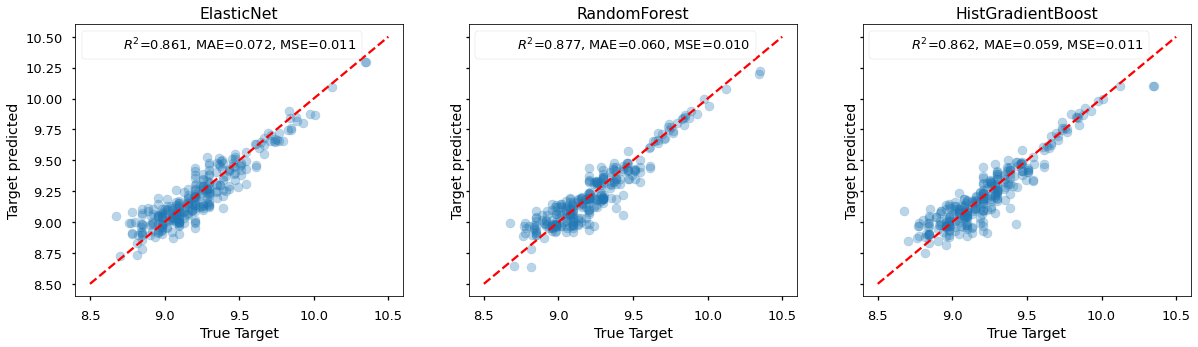

In [61]:
train_estimators(estimators, X_train, y_train, X_test, y_test)

INFO:sklearn_turbostart.train:['Feature 1', 'Feature 2', 'Feature 4', 'Feature 7', 'Feature 9', 'x0_1', 'x1_1', 'Feature 8', 'x0_1.0', 'x0_2.0', 'x1_1.0']
INFO:sklearn_turbostart.train:['Feature 1', 'Feature 2', 'Feature 4', 'Feature 7', 'Feature 9', 'x0_1', 'x1_1', 'Feature 8', 'x0_1.0', 'x0_2.0', 'x1_1.0']
INFO:sklearn_turbostart.train:['Feature 1', 'Feature 2', 'Feature 4', 'Feature 7', 'Feature 9', 'x0_1', 'x1_1', 'Feature 8', 'x0_1.0', 'x0_2.0', 'x1_1.0']


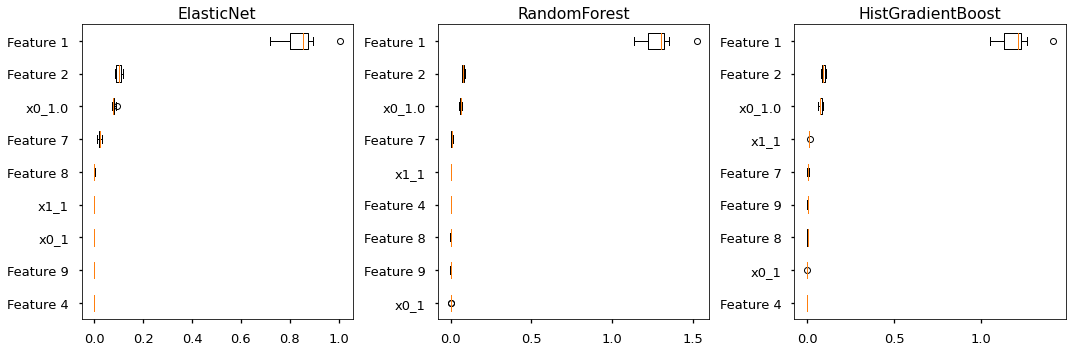

In [62]:
plot_permutation_importance(estimators, X_test, y_test)

Both tree based models indicate that Feature 1, Feature 2 and encoded Feature 3 is imporntant

## Removing Feature 4 and Feature 9 based on importance

In [63]:
X_train, y_train, X_test, y_test = load_data("../data/data.csv")

standard_scalar_numerical_columns = [
    "Feature 1",
    "Feature 2",
    "Feature 7",
]

categorical_columns = ["Feature 5", "Feature 6"]
categorical_pipe = Pipeline([("onehot", OneHotEncoder(drop="first"))])

missing_cat_pipeline = make_pipeline(
    SimpleImputer(
        missing_values=np.nan, strategy="constant", fill_value=2, add_indicator=True,
    ),
    OneHotEncoder(drop="first"),
)

preprocessing = ColumnTransformer(
    [
        (
            "numeric_standard_scalar",
            StandardScaler(),
            standard_scalar_numerical_columns,
        ),
        ("cat", categorical_pipe, categorical_columns),
        ("cat_ord", OrdinalEncoder(), ["Feature 8"]),
        ("missing_cat", missing_cat_pipeline, ["Feature 3"],),
    ]
)

estimators = create_estimators(preprocessing)
preprocessing

INFO:sklearn_turbostart.train:Transforming Y to log(Y)
INFO:sklearn_turbostart.train:Splitting data as 80/20


ColumnTransformer(transformers=[('numeric_standard_scalar', StandardScaler(),
                                 ['Feature 1', 'Feature 2', 'Feature 7']),
                                ('cat',
                                 Pipeline(steps=[('onehot',
                                                  OneHotEncoder(drop='first'))]),
                                 ['Feature 5', 'Feature 6']),
                                ('cat_ord', OrdinalEncoder(), ['Feature 8']),
                                ('missing_cat',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(add_indicator=True,
                                                                fill_value=2,
                                                                strategy='constant')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(drop='first'))]),
                                 ['Feature 3'])])

Estimator: ElasticNet
Training score: 0.820
Cross-val score: 0.817
Test score: 0.832
----------
Estimator: RandomForest
Training score: 0.900
Cross-val score: 0.835
Test score: 0.864
----------
Estimator: HistGradientBoost
Training score: 0.906
Cross-val score: 0.836
Test score: 0.858
----------


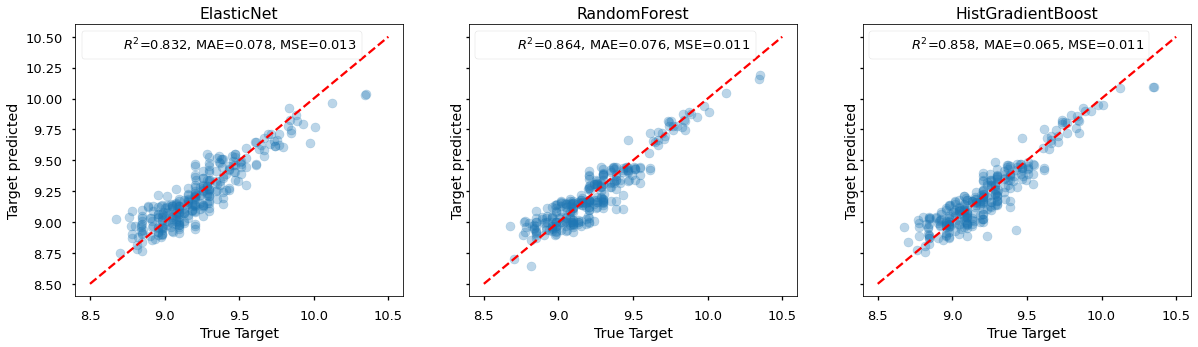

In [64]:
train_estimators(estimators, X_train, y_train, X_test, y_test)

INFO:sklearn_turbostart.train:['Feature 1', 'Feature 2', 'Feature 7', 'x0_1', 'x1_1', 'Feature 8', 'x0_1.0', 'x0_2.0', 'x1_1.0', 3, 8]
INFO:sklearn_turbostart.train:['Feature 1', 'Feature 2', 'Feature 7', 'x0_1', 'x1_1', 'Feature 8', 'x0_1.0', 'x0_2.0', 'x1_1.0', 3, 8]
INFO:sklearn_turbostart.train:['Feature 1', 'Feature 2', 'Feature 7', 'x0_1', 'x1_1', 'Feature 8', 'x0_1.0', 'x0_2.0', 'x1_1.0', 3, 8]


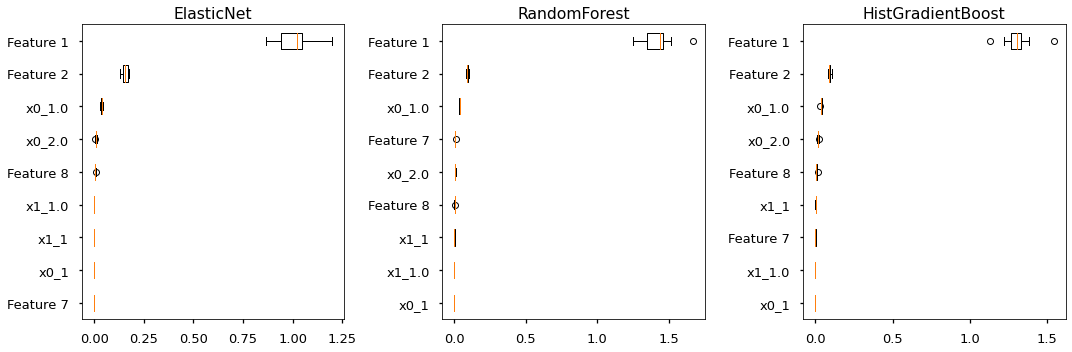

In [65]:
plot_permutation_importance(estimators, X_test, y_test)

This is not good. As the model has regressed.

## Is Feature 3 important?

In [66]:
X_train, y_train, X_test, y_test = load_data("../data/data.csv")

standard_scalar_numerical_columns = [
    "Feature 1",
    "Feature 2",
    "Feature 4",
    "Feature 7",
    "Feature 9",
]

categorical_columns = ["Feature 5", "Feature 6"]

preprocessing = ColumnTransformer(
    [
        (
            "numeric_standard_scalar",
            StandardScaler(),
            standard_scalar_numerical_columns,
        ),
        ("cat", OneHotEncoder(drop="first"), categorical_columns),
        ("cat_ord", OrdinalEncoder(), ["Feature 8"]),
    ]
)

estimators = create_estimators(preprocessing)
preprocessing

INFO:sklearn_turbostart.train:Transforming Y to log(Y)
INFO:sklearn_turbostart.train:Splitting data as 80/20


ColumnTransformer(transformers=[('numeric_standard_scalar', StandardScaler(),
                                 ['Feature 1', 'Feature 2', 'Feature 4',
                                  'Feature 7', 'Feature 9']),
                                ('cat', OneHotEncoder(drop='first'),
                                 ['Feature 5', 'Feature 6']),
                                ('cat_ord', OrdinalEncoder(), ['Feature 8'])])

Estimator: ElasticNet
Training score: 0.843
Cross-val score: 0.840
Test score: 0.861
----------
Estimator: RandomForest
Training score: 0.926
Cross-val score: 0.852
Test score: 0.878
----------
Estimator: HistGradientBoost
Training score: 0.927
Cross-val score: 0.851
Test score: 0.860
----------


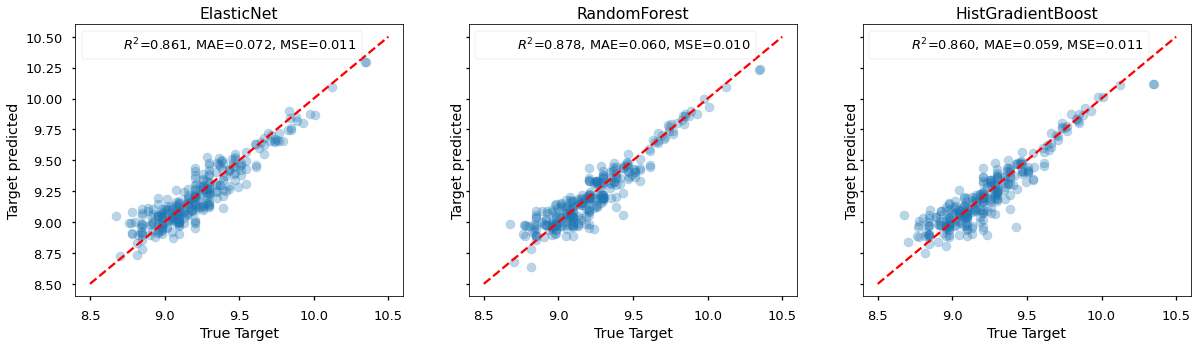

In [67]:
train_estimators(estimators, X_train, y_train, X_test, y_test)

Not having Feature 3 is better

## Using different feature transformers based on hypotheses

for some features as they are more robust to outliers and transforms variables to required normal distribution

In [68]:
X_train, y_train, X_test, y_test = load_data("../data/data.csv")

# Preprocessing
categorical_columns = ["Feature 5", "Feature 6", "Feature 8"]

missing_cat_pipeline = make_pipeline(
    SimpleImputer(
        missing_values=np.nan, strategy="constant", fill_value=2, add_indicator=True,
    ),
    OneHotEncoder(drop="first"),
)

preprocessing = ColumnTransformer(
    [
        ("numeric_standard_scalar", StandardScaler(), ["Feature 1"],),
        ("numeric_log_robust", QuantileTransformer(), ["Feature 2", "Feature 9"]),
        ("min_max", MinMaxScaler(), ["Feature 4", "Feature 7"]),
        ("onehot", OneHotEncoder(drop="first"), categorical_columns),
        ("missing_cat", missing_cat_pipeline, ["Feature 3"])
    ]
)

estimators = create_estimators(preprocessing)
preprocessing

INFO:sklearn_turbostart.train:Transforming Y to log(Y)
INFO:sklearn_turbostart.train:Splitting data as 80/20


ColumnTransformer(transformers=[('numeric_standard_scalar', StandardScaler(),
                                 ['Feature 1']),
                                ('numeric_log_robust', QuantileTransformer(),
                                 ['Feature 2', 'Feature 9']),
                                ('min_max', MinMaxScaler(),
                                 ['Feature 4', 'Feature 7']),
                                ('onehot', OneHotEncoder(drop='first'),
                                 ['Feature 5', 'Feature 6', 'Feature 8']),
                                ('missing_cat',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(add_indicator=True,
                                                                fill_value=2,
                                                                strategy='constant')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(drop='first'))]),
                                 ['Feature 3'])])

Estimator: ElasticNet
Training score: 0.831
Cross-val score: 0.827
Test score: 0.838
----------
Estimator: RandomForest
Training score: 0.912
Cross-val score: 0.852
Test score: 0.874
----------
Estimator: HistGradientBoost
Training score: 0.926
Cross-val score: 0.850
Test score: 0.861
----------


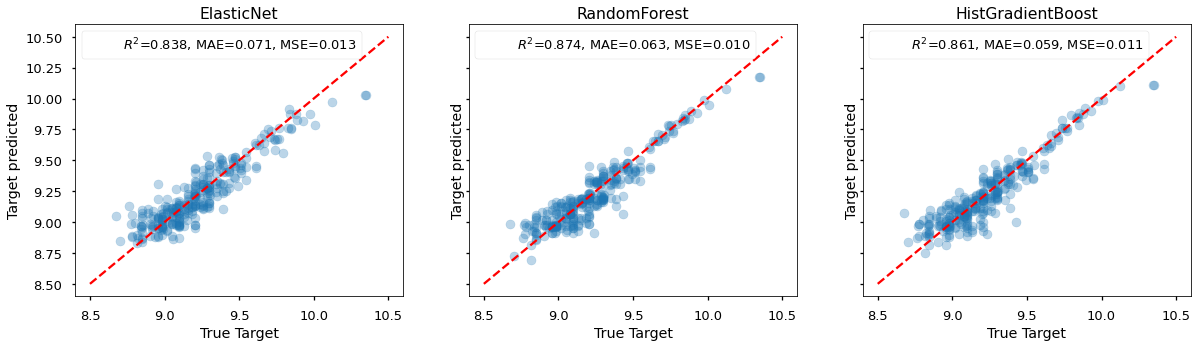

In [69]:
warnings.filterwarnings("ignore")
train_estimators(estimators, X_train, y_train, X_test, y_test)

In [70]:
estimators["HistGradientBoost"].best_estimator_

TransformedTargetRegressor(regressor=Pipeline(steps=[('preprocessor',
                                                      ColumnTransformer(transformers=[('numeric_standard_scalar',
                                                                                       StandardScaler(),
                                                                                       ['Feature '
                                                                                        '1']),
                                                                                      ('numeric_log_robust',
                                                                                       QuantileTransformer(),
                                                                                       ['Feature '
                                                                                        '2',
                                                                                        'Feature '
                                                                                        '9']),
                                                                                      ('min_max',
                                                                                       MinMaxScaler(),
                                                                                       ['Feature '
                                                                                        '4',
                                                                                        'Feature '
                                                                                        '7']),
                                                                                      ('onehot',
                                                                                       OneHotEncoder(drop='first'),
                                                                                       ['Feature '
                                                                                        '5',
                                                                                        'Feature '
                                                                                        '6',
                                                                                        'Feature '
                                                                                        '8']),
                                                                                      ('missing_cat',
                                                                                       Pipeline(steps=[('simpleimputer',
                                                                                                        SimpleImputer(add_indicator=True,
                                                                                                                      fill_value=2,
                                                                                                                      strategy='constant')),
                                                                                                       ('onehotencoder',
                                                                                                        OneHotEncoder(drop='first'))]),
                                                                                       ['Feature '
                                                                                        '3'])])),
                                                     ('regressor',
                                                      HistGradientBoostingRegressor(l2_regularization=1.0,
                                                                                    max_depth=6))]),
                           transformer=StandardScaler())

## After removing outliers in Feature 2. 

Hypothesis - Multiple Linear regression should improve. Tree-based methods are robust

Observation - Performance seems to have degraded


INFO:sklearn_turbostart.train:Transforming Y to log(Y)
INFO:sklearn_turbostart.train:Splitting data as 80/20


Estimator: ElasticNet
Training score: 0.842
Cross-val score: 0.840
Test score: 0.861
----------
Estimator: RandomForest
Training score: 0.924
Cross-val score: 0.849
Test score: 0.872
----------
Estimator: HistGradientBoost
Training score: 0.927
Cross-val score: 0.849
Test score: 0.858
----------


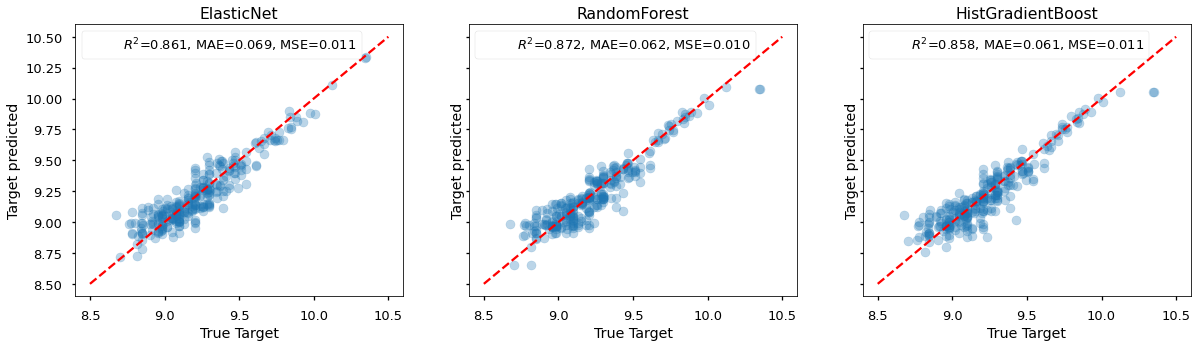

In [71]:
X_train, y_train, X_test, y_test = load_data("../data/data.csv")
standard_scalar_numerical_columns = [
    "Feature 1",
    "Feature 2",
    "Feature 4",
    "Feature 7",
    "Feature 9",
]

categorical_columns = ["Feature 5", "Feature 6", "Feature 8"]
categorical_pipe = Pipeline([("onehot", OneHotEncoder(drop="first"))])

missing_cat_pipeline = make_pipeline(
    SimpleImputer(
        missing_values=np.nan, strategy="constant", fill_value=2, add_indicator=True,
    ),
    OneHotEncoder(drop="first"),
)

preprocessing = ColumnTransformer(
    [
        (
            "numeric_standard_scalar",
            StandardScaler(),
            standard_scalar_numerical_columns,
        ),
        ("cat", categorical_pipe, categorical_columns),
        ("missing_cat", missing_cat_pipeline, ["Feature 3"],),
    ]
)
estimators = create_estimators(preprocessing)

non_outliers = X_train["Feature 2"] > 1000
X_train = X_train[non_outliers]
y_train = y_train[non_outliers]
train_estimators(estimators, X_train, y_train, X_test, y_test)